# Tree-based Models, with Clusters

## Library Imports

In [1]:
# Library imports
import numpy as np
import pandas as pd
from pandas import MultiIndex, Int16Dtype
from category_encoders import TargetEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from matplotlib import pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_absolute_percentage_error
from Common_Functions import (data_split,
                              add_unique_identifier,
                              data_cleaning,
                              hospital_data_agg,
                              standardize_data,
                              optimal_k,
                              impute_knn
                             )
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

C:\Users\rogmo\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## Data Import

In [2]:
# Data is imported from our preprocessed file
data = pd.read_csv("Feature Matrix/processed_data.csv")
# Exclude all rows where mcare_count = 0
data.dropna(subset = ['mcare_count'], inplace = True)
# Drop year
data.drop(columns = ['year'], inplace = True)
# Replace infinities with zeroes to allow later preprocessing steps to function
data.replace([np.inf, -np.inf], 0, inplace=True)

## Model Parameters

In [3]:
# Threshold for our private count. Any rows with more than this value will be included in our model
COUNT_THRESH = 34
# Random seed for reproducibility
RDM_SEED = 123
# Train/Test ratio
TRAIN_TEST_PROPORTION = 0.8
# Monotonicity flag
MONOTONE_SITE = True

## Data Transformation

### One-Hot Categorical Encoding and Dropping NAs

In [4]:
# Perform data one hot encoding and dropping NAs, if applicable
data = data_cleaning(data, dropna = False, one_hot = False)

### Data Split

In [5]:
# Split data in to the working set to be used in model building and a predict set,
# which will not be used for model building or evaluation
working_set, predict_set = data_split(data, count_thresh = COUNT_THRESH)

In [6]:
model_data = working_set
predict_data = predict_set

In [7]:
# Preview model data
display(model_data)

,site,group,priv_count,priv_pay_median,mcare_los,mcare_pay_median,CBSA_NAME,lon,lat,Hospitals,...,annual_births,frac_veteran,frac_disability,non_citizen,employment_rate,frac_priv_insurance,frac_mcare_insurance,frac_no_insurance,cluster,mcare_count
40,1,breast reconstruction,63,24289.900,2.549296,8794.190,"Dallas-Fort Worth-Arlington, TX",-96.920913,32.707875,114.0,...,1974825.0,0.06,0.10,0.59,0.69,0.66,0.25,0.17,0,71.0
70,1,breast reconstruction,51,21408.000,3.543210,10395.160,"Houston-The Woodlands-Sugar Land, TX",-95.622552,29.598443,181.0,...,1808878.0,0.05,0.10,0.57,0.66,0.60,0.28,0.19,0,81.0
112,1,breast reconstruction,64,29757.100,3.918699,14174.100,"New York-Newark-Jersey City, NY-NJ-PA",-74.005954,40.712776,143.0,...,4668590.0,0.03,0.11,0.41,0.65,0.66,0.39,0.07,0,123.0
219,1,breast reconstruction,66,25240.905,3.241935,10144.445,"Dallas-Fort Worth-Arlington, TX",-96.920913,32.707875,114.0,...,1974825.0,0.06,0.10,0.59,0.69,0.66,0.25,0.17,0,62.0
275,1,breast reconstruction,45,34963.900,3.262295,14008.190,"New York-Newark-Jersey City, NY-NJ-PA",-74.005954,40.712776,143.0,...,4668590.0,0.03,0.11,0.41,0.65,0.66,0.39,0.07,0,122.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44974,0,ant_cerv_fusion,54,17137.490,NaN,6934.483,"Atlanta-Sandy Springs-Alpharetta, GA",-84.294090,34.075380,80.0,...,1573561.0,0.07,0.11,0.48,0.67,0.70,0.28,0.12,2,0.0
44991,0,ant_cerv_fusion,39,11807.250,NaN,6905.252,"Charlotte-Concord-Gastonia, NC-SC",-80.721440,35.122320,26.0,...,673803.0,0.06,0.11,0.57,0.67,0.69,0.31,0.10,2,0.0
45038,0,ant_cerv_fusion,35,18421.250,NaN,6724.500,"Memphis, TN-MS-AR",-89.850500,35.038720,28.0,...,327202.0,0.07,0.13,0.64,0.64,0.64,0.37,0.11,2,0.0
45100,0,ant_cerv_fusion,51,13926.250,NaN,7334.787,"Atlanta-Sandy Springs-Alpharetta, GA",-84.294090,34.075380,80.0,...,1573561.0,0.07,0.11,0.48,0.67,0.70,0.28,0.12,2,0.0


## Dev/Test Split

In [8]:
# Split our data into features and target
X_input = model_data.drop(columns=["priv_pay_median"])
y_input = model_data["priv_pay_median"]

# Perform dev/test split
X_dev, X_test, y_dev, y_test = train_test_split(X_input,
                                                y_input,
                                                train_size = TRAIN_TEST_PROPORTION,
                                                random_state = RDM_SEED)

# Uncomment the below line to preview dev data, if desired
# display(X_dev)

## Split Model Data by Cluster

In [9]:
# Initialize various lists. These will be used to store our clustered datasets and optimal k's for KNN imputation
X_dev_list = []
X_dev_groups = []
y_dev_list = []
X_test_list = []
X_test_groups = []
y_test_list = []
optimal_k_list = []

# Iterate through clusters
for cluster_label in model_data["cluster"].unique():
    # Create new datasets for each cluster in our dev and test data
    X_dev_clu = X_dev[X_dev["cluster"] == cluster_label].copy()
    y_dev_clu = y_dev[X_dev["cluster"] == cluster_label].copy()
    X_test_clu = X_test[X_test["cluster"] == cluster_label].copy()
    y_test_clu = y_test[X_test["cluster"] == cluster_label].copy()
    
    # Target encode group variable
    te_group = TargetEncoder(min_samples_leaf=1, smoothing=1.0)
    X_dev_clu['group_encoded'] = te_group.fit_transform(X_dev_clu['group'],y_dev_clu)
    dev_group = X_dev_clu['group']
    X_dev_clu.drop(columns = 'group', inplace = True)
    X_test_clu['group_encoded'] = te_group.transform(X_test_clu['group'])
    test_group = X_test_clu['group']
    X_test_clu.drop(columns = 'group', inplace = True)

    # Target encode CBSA Name
    te_CBSA_NAME = TargetEncoder(min_samples_leaf=1, smoothing=1.0)
    X_dev_clu['CBSA_NAME_encoded'] = te_CBSA_NAME.fit_transform(X_dev_clu['CBSA_NAME'],y_dev_clu)
    X_dev_clu.drop(columns = 'CBSA_NAME', inplace = True)
    X_test_clu['CBSA_NAME_encoded'] = te_CBSA_NAME.transform(X_test_clu['CBSA_NAME'])
    X_test_clu.drop(columns = 'CBSA_NAME', inplace = True)
    
    # Perform KNN Imputation
    knn_data = X_dev_clu.copy()
    knn_data['priv_pay_median'] = y_dev_clu
    
    # First, find optimal k
    optimal_k_list.append(optimal_k(knn_data))
    
    # Then, apply the optimal k to perform KNN imputation
    X_dev_clu, X_test_clu = impute_knn(X_dev_clu, X_test_clu, optimal_k_list[-1])
    
#     Uncomment the below line to preview dev data by cluster, if desired
#     display(X_dev_clu)
    
    # Add clustered datasets to our lists
    X_dev_list.append(X_dev_clu)
    X_dev_groups.append(dev_group.reset_index().drop(columns=["index"]))
    y_dev_list.append(y_dev_clu)
    X_test_list.append(X_test_clu)
    X_test_groups.append(test_group.reset_index().drop(columns=["index"]))
    y_test_list.append(y_test_clu)
    
#     For statistics about the relative dev/test ratio for a cluster, uncomment the below line
#     print(X_dev_clu.shape[0] / X_test_clu.shape[0])

## Run XGBoost model

Results for cluster: 0
Feature importances:


,feature,importance
30,cluster,0.000000
0,priv_count,0.000315
10,State_Poverty_Percent_All_Ages,0.000892
3,Hospitals,0.001091
4,PctTeaching,0.001400
13,num_races,0.001717
6,PctPrivate,0.001804
11,State_Median_Household_Income,0.001848
12,income_pc,0.001938
27,mcare_count,0.002129


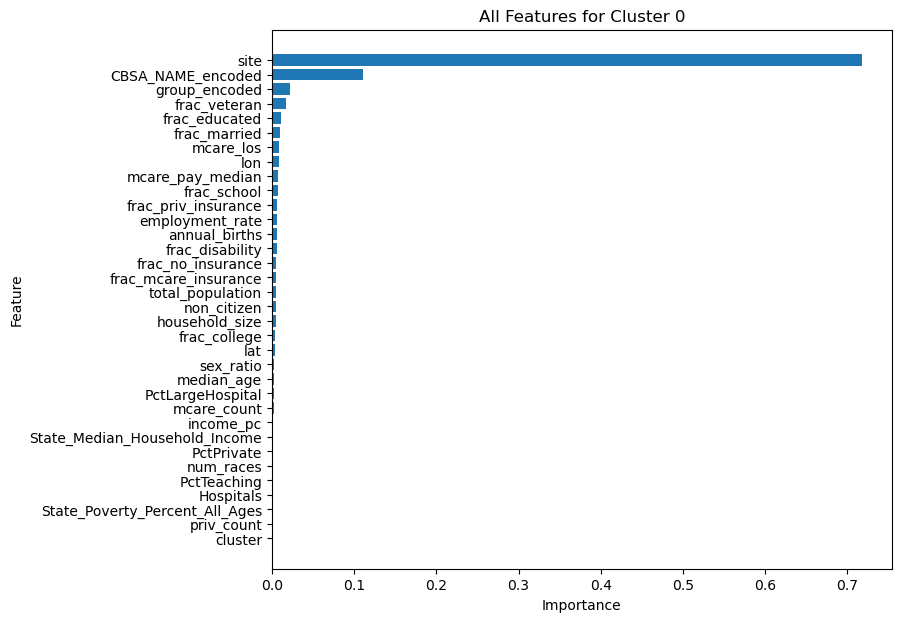

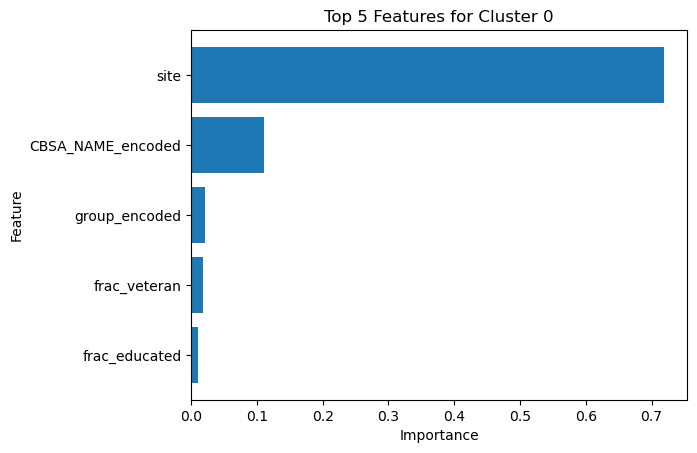

Results for cluster: 2
Feature importances:


,feature,importance
30,cluster,0.000000
0,priv_count,0.001152
1,mcare_los,0.005763
27,mcare_count,0.005781
11,State_Median_Household_Income,0.006303
12,income_pc,0.006588
8,median_age,0.007721
4,PctTeaching,0.007999
10,State_Poverty_Percent_All_Ages,0.008378
16,frac_school,0.009684


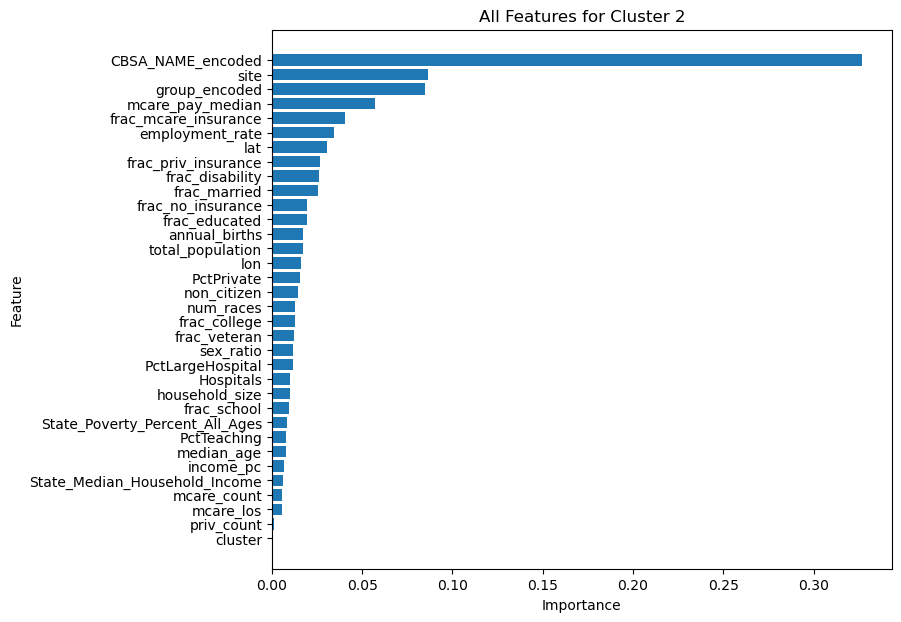

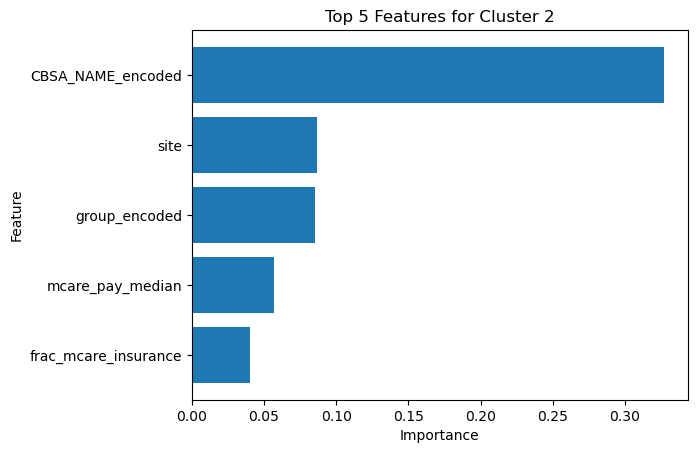

Results for cluster: 1
Feature importances:


,feature,importance
31,site,0.000000
30,cluster,0.000000
0,priv_count,0.001171
10,State_Poverty_Percent_All_Ages,0.003919
12,income_pc,0.004392
27,mcare_count,0.005366
5,PctLargeHospital,0.005684
11,State_Median_Household_Income,0.005867
3,Hospitals,0.006436
1,mcare_los,0.009963


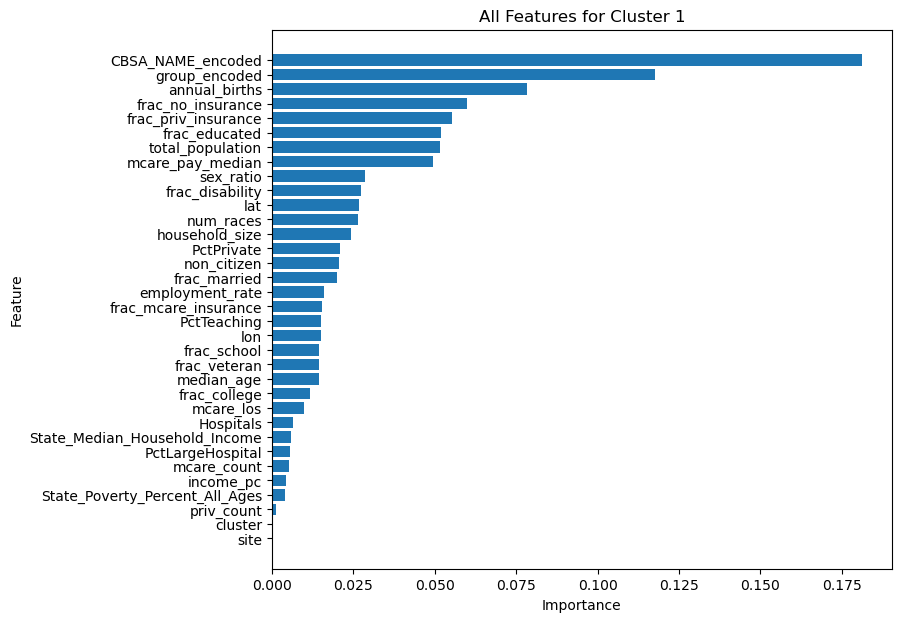

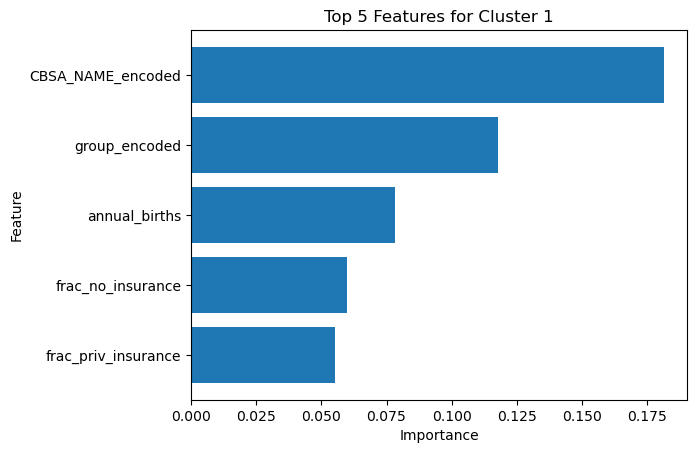

In [10]:
# Initialize lists for cluster MAPEs
train_mapes = []
train_sizes = []
test_mapes = []
test_sizes = []
cluster_numbers = []

# Initialize dictionary for procedure results
proc_results_dict = {}

# Train test split
for idx in range(0,len(X_dev_list)):
    cluster_being_modeled = int(X_dev_list[idx].head(1)['cluster'])
    print(f"Results for cluster: {cluster_being_modeled}")
    cluster_numbers.append(cluster_being_modeled)
    
    # Parameterization
    # Monotonicity constraint
    mono = {'site': 1}

    # Parameters to be used for tuning. Certain parameters used for model tuning are commented out
    param_grid = {
#         'booster':['gbtree','dart'],
        'colsample_bylevel':[1],
        'colsample_bytree':[1],
        'enable_categorical':[False],
        'gamma':[0],
        'gpu_id':[-1],
        'interaction_constraints':[''],
        'max_delta_step':[0],
        'min_child_weight':[1],
        'missing':[np.nan],
#         'n_estimators':[100,175,250],
        'n_jobs':[8],
        'predictor':['auto'],
        'reg_alpha':[0],
        'scale_pos_weight':[1],
        'tree_method':['exact'],
        'validate_parameters':[1],
        'learning_rate':[1],
#         'max_depth':[10,17,25],
        'num_parallel_tree':[250],
        'objective':['reg:squarederror'],
        'subsample':[0.8],
        'random_state':[RDM_SEED],
#         'reg_lambda':[0,0.25,0.5]
    }
    
    # Create the model
    if MONOTONE_SITE:
        xgb_param_tuning_model = xgb.XGBRFRegressor(monotone_constraints = mono,
                                                    n_estimators = 250,
                                                    max_depth=25,
                                                    reg_lambda=0,
                                                    booster = 'gbtree'
                                                   )
    else:
        xgb_param_tuning_model = xgb.XGBRFRegressor(
                                                    n_estimators = 250,
                                                    max_depth=25,
                                                    reg_lambda=0,
                                                    booster = 'gbtree'
                                                   )
    
    # Run, tune (if applicable), and fit the model
    xgb_mono_model = GridSearchCV(xgb_param_tuning_model, param_grid, scoring='neg_mean_absolute_percentage_error')
    xgb_mono_model.fit(X_dev_list[idx], y_dev_list[idx])
    
    # Uncomment below line to output optimal params (if applicable)
#     print(f"Best parameters (if grid search was applied): {xgb_mono_model.best_params_}")
    # Uncomment below line to output validation score
#     print(f"Validation score: {xgb_mono_model.best_score_}")
    # Output model feature imoprtances - both as a table and as graphs
    print(f"Feature importances:")
    import_df = pd.concat([pd.Series(X_dev_list[idx].columns,name="feature"), pd.Series(xgb_mono_model.best_estimator_.feature_importances_,name="importance")], axis=1)
    import_df = import_df.sort_values(by="importance")
    display(import_df)
    plt.figure(figsize=(8,7))
    plt.barh(y = import_df["feature"], width = import_df["importance"])
    plt.title(("All Features for Cluster " + str(cluster_being_modeled)))
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.show()
    plt.barh(y = import_df["feature"].tail(5), width = import_df["importance"].tail(5))
    plt.title(("Top 5 Features for Cluster " + str(cluster_being_modeled)))
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.show()
    
    # Predict on train and test data
    y_train_pred_xgb = xgb_mono_model.predict(X_dev_list[idx])
    y_test_pred_xgb = xgb_mono_model.predict(X_test_list[idx])
    
    # Get results for individual procedure groups
    for proc in X_test_groups[idx]["group"].unique():
        actuals_test_w_proc = y_test_list[idx].reset_index().drop(columns=["index"]).join(X_test_groups[idx])
        pred_with_proc = pd.Series(y_test_pred_xgb)[actuals_test_w_proc["group"] == proc]
        proc_results_dict[proc] = mean_absolute_percentage_error(y_true=actuals_test_w_proc[actuals_test_w_proc["group"] == proc]["priv_pay_median"], y_pred=pred_with_proc)
        # To output the number of claims per procedure, uncomment the following line
#         print(f"Count of claims for {proc}: {len(pred_with_proc)}")

    # Store general model results
    train_sizes.append(len(X_dev_list[idx]))
    test_sizes.append(len(X_test_list[idx]))
    train_mapes.append(mean_absolute_percentage_error(y_true=y_dev_list[idx], y_pred=y_train_pred_xgb))
    test_mapes.append(mean_absolute_percentage_error(y_true=y_test_list[idx], y_pred=y_test_pred_xgb))
    
train_mapes = np.array(train_mapes)
train_sizes = np.array(train_sizes)
test_mapes = np.array(test_mapes)
test_sizes = np.array(test_sizes)

In [11]:
# Output general results
print(f"Monotonic Random Forest with Threshold >{COUNT_THRESH} claims for training set:")
results_df = pd.DataFrame(list(zip(cluster_numbers, train_mapes, test_mapes)),
                           columns =['Cluster', 'Train MAPE', 'Test MAPE']).sort_values(by="Cluster").set_index('Cluster')
# Print cluster results
print(f"Cluster MAPE Values:")
display(results_df)

# For individual MAPEs and dataset sizes, uncomment the below lines
# print(f"Clusters: {cluster_numbers}")
# print(f"Train MAPEs: {train_mapes}")
# print(f"Train sizes: {train_sizes}")
# print(f"Test MAPEs: {test_mapes}")
# print(f"Test sizes: {test_sizes}")
print(f"Overall train MAPE: {((train_mapes * train_sizes) / (train_sizes.sum())).sum()}")
print(f"Overall test MAPE: {((test_mapes * test_sizes) / (test_sizes.sum())).sum()}")

Monotonic Random Forest with Threshold >34 claims for training set:
Cluster MAPE Values:


,Train MAPE,Test MAPE
Cluster,,
0,0.042962,0.140269
1,0.025405,0.180076
2,0.031639,0.153401


Overall train MAPE: 0.03820359866275739
Overall test MAPE: 0.14719437836710014


,Test MAPE
ant_tls_fusion,0.057012
prox_tibia_fixation,0.074693
tha,0.076632
cardiac ablation_additional_discrete,0.090161
clavicle fixation,0.099747
tsa,0.099877
robotic_assisted_surgery,0.101669
post_tls_fusion,0.106836
radius/ulna internal fixation,0.117275
navigation,0.118818


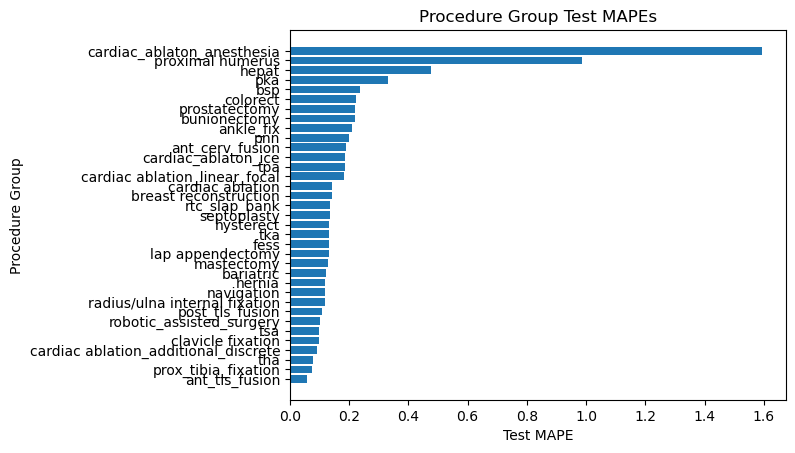

In [12]:
# Output procedure group results
proc_results_df = pd.DataFrame.from_dict(proc_results_dict, orient="index",columns=["Test MAPE"]).sort_values(by="Test MAPE")
display(proc_results_df)
plt.barh(y = proc_results_df.index, width = proc_results_df["Test MAPE"])
plt.title("Procedure Group Test MAPEs")
plt.xlabel("Test MAPE")
plt.ylabel("Procedure Group")
plt.show()